# Ofset free MPC using matric C

In [6]:
import numpy as np
from numpy.linalg import inv
#import pandas as pd
import joblib
import matplotlib.pyplot as plt
import cvxpy as cp
#from torch.utils.data import DataLoader
import torch
#from sklearn.preprocessing import StandardScaler
import os
import sys

from neuromancer.system import Node, System
#from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
#from neuromancer.dataset import DictDataset
#from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load matrices, model, scalers and load process

In [7]:
append = "_parsimK"
A = np.load('../data/A' + append + '.npy')
B = np.load('../data/B' + append + '.npy')
C = np.load('../data/C' + append + '.npy')

nz, nu = B.shape  # state and input dimensions
ny = C.shape[0]  # output dimensions

# disturbance 
F = np.eye(ny)
nd = F.shape[1]

In [8]:
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))


Close to block diagonal? True
Backtransformation equals original A? True


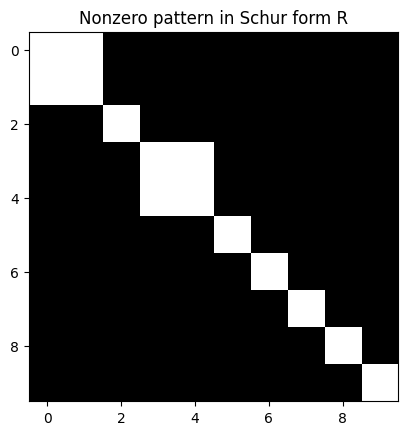

In [9]:
import matplotlib.pyplot as plt
plt.imshow(np.abs(A_transformed) > 1e-6, cmap='gray')
plt.title("Nonzero pattern in Schur form R")
plt.show()

In [10]:
A = A_block
B = inv(T_real) @ B
C = C @ T_real


In [11]:
# model parameters

layers = [20,40,60]
layers_dec  = [60,40,20]


In [12]:
# load scalers
scaler = joblib.load('../data/scaler.pkl')
scalerU = joblib.load('../data/scalerU.pkl')

In [13]:
# define same model as for training
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

Necesary?

## Optimal control problem

Observer - Kalman filter

In [14]:
loaded_setup = joblib.load("sim_setup.pkl")

In [15]:
y_start = loaded_setup['y_start']

y_setpoint = loaded_setup['reference'][:,0]

u_previous = loaded_setup['u_previous']

z_est_ = np.hstack(((np.linalg.pinv(C)@y_start.T).T, np.zeros((1,nd))))

P0 = loaded_setup['P0']

# Noise covariances
Q = loaded_setup['Q']  # process noise
R = loaded_setup['R']  # measurement noise
A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)]
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu))
])

C_ = np.hstack([
    C, np.eye(nd)
])

KF = helper.KF(A_,B_,C_,z_est_,P0, Q, R)



Target calculation

In [16]:
target_estimation = helper.TargetEstimation(A, B, C)


In [17]:
z_s, y_s = target_estimation.get_target( z_est_[:,nz:],y_setpoint)
print("Status:",target_estimation.te.status)
print("Optimal y:", scaler.inverse_transform(y_s.reshape(1,-1)))

z_ref = z_s

Set parameter Username
Set parameter LicenseID to value 2631450
Academic license - for non-commercial use only - expires 2026-03-05
Status: optimal
Optimal y: [[0.50000006 0.49999996]]


MPC problem formulation


In [18]:
mpc = helper.MPC(A, B, C)

In [19]:
u_opt = mpc.get_u_optimal(z_est_[:,:nz], z_est_[:,nz:], u_previous, z_ref)
print(u_opt)
print(mpc.mpc.status)

[-0.92128905  0.02469406]
optimal


In [20]:
import time

sim_time = loaded_setup['sim_time']
Ts = 1
z_sim = np.zeros((nz+nd, sim_time+1))
y_sim = np.zeros((ny, sim_time+1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time+1))
zs_sim = np.zeros((nz, sim_time+1))

total_time_target = 0
total_time_mpc = 0

start_time_target = time.time()
z_s, y_s = target_estimation.get_target(z_est_[:,nz:],y_setpoint)
end_time_target = time.time()
#print(f"Target estimation solve time: {end_time_target - start_time_target:.4f} seconds")
total_time_target += end_time_target - start_time_target

y_sim_descaled = np.zeros((ny, sim_time+1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value
#print(scalerU.inverse_transform(u_prev.reshape(1,-1)))
u_sim_descaled[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1,-1))[0]
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1,-1))[0]

for k in range(0,sim_time):
    
    # solve MPC
    start_time_mpc = time.time()
    u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], u_prev, zs_sim[:, k])
    end_time_mpc = time.time()
    
    #print(f"MPC solve time at step {k}: {end_time_mpc - start_time_mpc:.4f} seconds")
    total_time_mpc += end_time_mpc - start_time_mpc
    
    u_sim[:, k] = u_opt
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1,-1))[0]
    
    # simulate system
    y_sim_descaled[:, k+1] =  TwoTanks.step(y_sim_descaled[:, k], u_sim_descaled[:, k].reshape(1,-1), Ts)
    
    y_sim[:, k+1] = scaler.transform(y_sim_descaled[:, k+1].reshape(1,-1))[0]
    
    # estimate state
    z_sim[:, k+1] = KF.step(u_sim[:, k], y_sim[:, k]).flatten()
    
    # estimate target
    
    start_time_target = time.time()
    zs_sim[:, k+1], ys_sim[:, k+1] = target_estimation.get_target(z_sim[nz:, k+1], loaded_setup["reference"][:, k])
    end_time_target = time.time()
    #print(f"Target estimation solve time at step {k}: {end_time_target - start_time_target:.4f} seconds")
    total_time_target += end_time_target - start_time_target
    
    u_prev = u_sim[:, k]

print(f"Total time spent in target estimation: {total_time_target:.4f} seconds")
print(f"Total time spent in MPC solve: {total_time_mpc:.4f} seconds")

Total time spent in target estimation: 0.6811 seconds
Total time spent in MPC solve: 4.6833 seconds


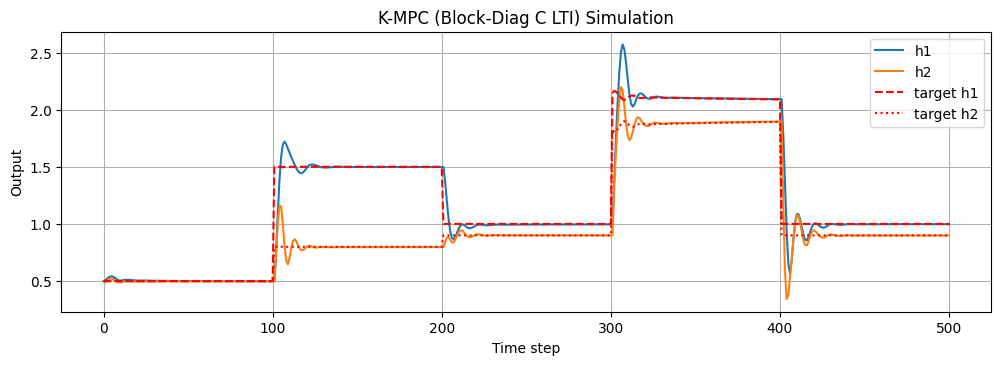

In [21]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_sim_descaled[0,:], label='h1')
plt.plot(y_sim_descaled[1,:], label='h2')
plt.plot(scaler.inverse_transform(ys_sim.T).T[0,:], color='red', linestyle='--', label='target h1')
plt.plot(scaler.inverse_transform(ys_sim.T).T[1,:], color='red', linestyle=':', label='target h2')
plt.title('K-MPC (Block-Diag C LTI) Simulation')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True) 

In [22]:
y_setpoint = loaded_setup['reference'][:,100]

In [23]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [24]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

No sustained convergence found.


In [25]:
from numpy import trapz

# Compute ISE for y_sim starting from step 50
ise_h1 = trapz((y_sim[0, :-1] - loaded_setup["reference"][0])**2)
ise_h2 = trapz((y_sim[1, :-1] - loaded_setup["reference"][1])**2)

print(f"ISE for h1 (from step 50): {ise_h1}")
print(f"ISE for h2 (from step 50): {ise_h2}")


ISE for h1 (from step 50): 15.22298084321595
ISE for h2 (from step 50): 15.805153908139548


In [26]:

# Compute the closed-loop value of the objective function

objective_value = 0
for k in range(1,sim_time):
    y_diff = y_sim[:, k] - loaded_setup["reference"][:,k]
    u_diff = u_sim[:, k] - u_sim[:, k-1]
    objective_value += y_diff.T @ loaded_setup["Qy"] @ y_diff 
    objective_value += u_diff.T @ loaded_setup["Qu"] @ u_diff
    #print(f"Objective value at step {k}: {objective_value}")

print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 180.47090700086738


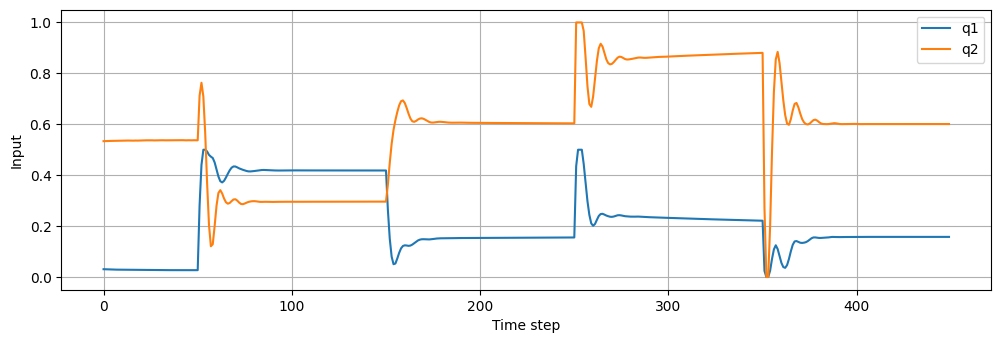

In [27]:
# plot results
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_sim_descaled[0,50:], label='q1')
plt.plot(u_sim_descaled[1,50:], label='q2')
plt.xlabel('Time step')
plt.ylabel('Input')
plt.legend()
plt.grid(True) 

In [28]:
u_sum_abs = np.sum(np.abs(u_sim_descaled), axis=1)
print(u_sum_abs)

[ 98.88516398 290.5029476 ]


/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_78983/665729309.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


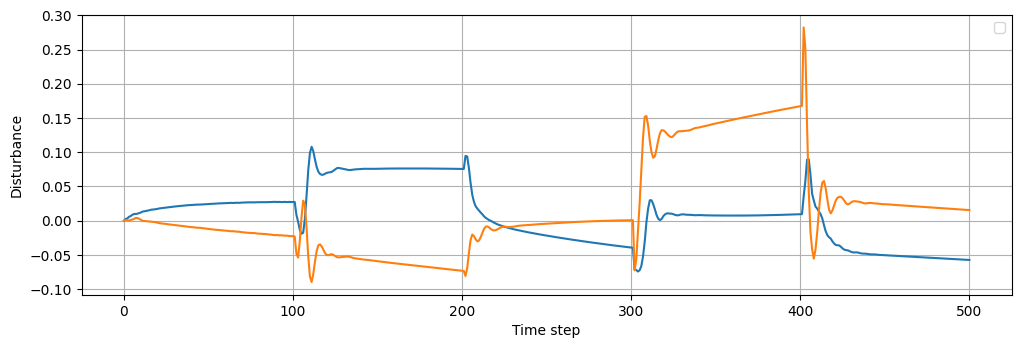

In [29]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(z_sim[nz:,0:].T)
plt.xlabel('Time step')
plt.ylabel('Disturbance')
plt.legend()
plt.grid(True)

In [30]:
scalerU.scale_

array([0.14911892, 0.29077111])

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_78983/126301668.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


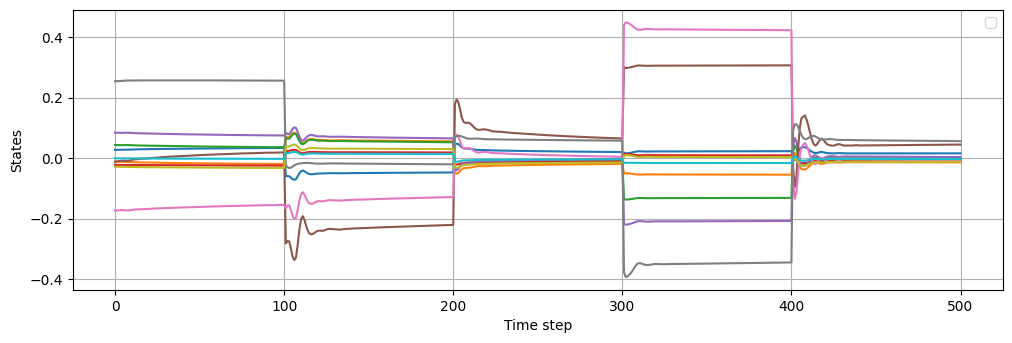

In [31]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(zs_sim[:nz].T)
plt.xlabel('Time step')
plt.ylabel('States')
plt.legend()
plt.grid(True)

/var/folders/js/50fn0f5j3g376mmr6z71dh5r0000gn/T/ipykernel_78983/1443504087.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


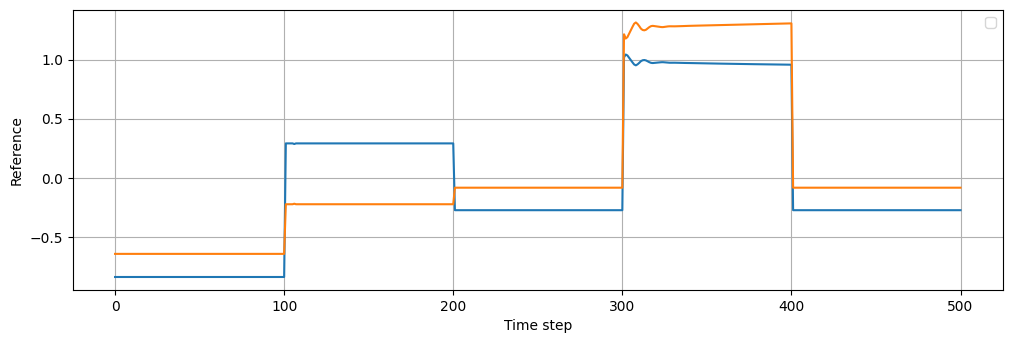

In [32]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(ys_sim.T)
plt.xlabel('Time step')
plt.ylabel('Reference')
plt.legend()
plt.grid(True)